# **Entrega 3 - Ciencia de datos aplicada**
## **Reducción de accidentes viales en Bogotá**

### GSD+ & SDM Bogotá

### **Integrantes**
*   Yachay J. Tolosa Bello – 202315750
*   Kevin Infante Hernández – 201117324
*   John Vicente Moreno Triviño – 202210162

### **Objetivo**
*   Determinar los lugares y momentos prioritarios para llevar a cabo intervenciones enfocadas en reducir la siniestralidad y orientar el tipo de acciones a desplegar allí.

In [1]:
# pip install - r requirements.txt > /dev/null

In [2]:
import geopandas as gpd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
from holidays import country_holidays
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from transformers_methods import sin_transformer, cos_transformer

Cargamos los datos de accidentes

In [3]:
accidentes_df = pd.read_csv("data/dataset_preparado.csv.gz", low_memory=False)

Cargamos la información geográfica de Bogotá y eliminamos la zona de Sumapaz

In [4]:
mapa_bogota = gpd.read_file("data/bogota_cadastral.json")
mapa_bogota_no_sumapaz = mapa_bogota.cx[:, 4.45422:]

In [5]:
def asignar_cuadrante(df, cols=13, rows=21):
    """
    Asigna a cada punto un cuadrante dada el tamaño de maya definida por cols y rows
    """

    bottomLeft = (4.45422, -74.22446)
    bottomRight = (4.45422, -73.99208494428275)
    topLeft = (4.833779672812246, -74.22446)

    cols = np.linspace(bottomLeft[1], bottomRight[1], num=cols + 1)
    rows = np.linspace(bottomLeft[0], topLeft[0], num=rows + 1)
    col = np.searchsorted(cols, df["X"]) - 1
    row = np.searchsorted(rows, df["Y"]) - 1
    df['cuadrante'] = row * (len(cols) - 1) + col
    df['columna'] = row + 1
    df['fila'] = col + 1

    cuadrantes_cord = []
    for i in range(len(rows) - 1):
        for j in range(len(cols) - 1):
            poly = shapely.geometry.box(cols[j], rows[i], cols[j + 1], rows[i + 1])
            cuadrantes_cord.append(poly)

    grid = gpd.GeoDataFrame(
        cuadrantes_cord, columns=["geometry"], crs=mapa_bogota_no_sumapaz.crs
    ).sjoin(mapa_bogota_no_sumapaz)[['geometry']].drop_duplicates()

    return df, grid


def enriquecer_fechas(df_base):
    """
    Agrega información al data set con base en la fecha de ocurrencia del accidente
    """
    
    df_base["hora"] = df_base.fecha_y_hora.dt.hour
    df_base["semana_del_año"] = df_base.fecha_y_hora.dt.isocalendar().week
    df_base["dia_de_la_semana"] = df_base.fecha_y_hora.dt.weekday
    df_base["mes"] = df_base.fecha_y_hora.dt.month

    colombian_holidays = country_holidays("CO")

    holidays = pd.DataFrame(
        index=pd.date_range(df_base.fecha_y_hora.min(), df_base.fecha_y_hora.max(), freq="d", normalize=True)
    )

    holidays["festivo"] = np.where(
        holidays.index.map(lambda x: x in colombian_holidays), 1, 0
    )

    df_base["fecha_truncada"] = df_base["fecha_y_hora"].dt.floor("d")

    df_base = df_base.join(holidays, on="fecha_truncada").drop(columns="fecha_truncada")

    return df_base


def crear_dataset(df, lapso="1h", cols=13, rows=21):
    """
    Crea un dataset de una grilla espacio temporal y marca cada cuadrante según el número de accidentes ocurridos
    """

    # Asignamos los cuadrantes
    df, grid = asignar_cuadrante(df, cols, rows)

    fecha_y_hora = pd.to_datetime(df["FECHA_OCURRENCIA_ACC"].str[:11] + df["HORA_OCURRENCIA_ACC"].str[:2])

    fechas = pd.DataFrame(
        pd.date_range(fecha_y_hora.min(), fecha_y_hora.max(), freq="1h"),
        columns=["fecha_y_hora"],
    )

    cuadrantes = df[["cuadrante", "fila", "columna"]].drop_duplicates()

    # Creamos una tabla del producto cartesiano entre los cuadrantes y las fechas
    df_base = fechas.merge(cuadrantes, how="cross")

    # Agregamos el número de accidentes y marcamos en cero cuando no hay accidentes. 
    df_base = df_base.join(
        df.groupby([fecha_y_hora, "cuadrante"]).size().rename("n_accidentes"),
        on=["fecha_y_hora", "cuadrante"]
    ).fillna(0)

    # Re-muestreamos para tener los intervalos de tiempo del tamaño deseado
    result = df_base.groupby(["cuadrante", "columna", "fila", pd.Grouper(key="fecha_y_hora", freq=lapso)],
                             as_index=False).sum()

    # creamos la variable accidentes indicando si hubo o no accidentes
    result["accidentes"] = np.where(result["n_accidentes"] > 1, 1, 0)

    result = enriquecer_fechas(result)

    # Trabajamos con datos rezagados 7 para poder hacer predicciones 7 días adelante
    df_rezagados = result.set_index(["fecha_y_hora"]).groupby("cuadrante").shift(7, freq="d")

    # Hubo accidentes hace n días a la misma hora:
    df_accidente_dias_rezagados = pd.concat([
        df_rezagados.groupby("cuadrante").shift(n, freq="d").set_index("cuadrante", append=True)["accidentes"].rename(
            f"accidente_{7 + n}_dias_antes_misma_hora")
        for n in range(30)
    ], axis=1).dropna()

    # Proporción de horas con accidentes en los últimos n días a la misma hora:
    df_accidente_dias_media_movil = pd.concat([
        df_accidente_dias_rezagados[[f"accidente_{7 + n}_dias_antes_misma_hora" for n in range(n)]].mean(axis=1).fillna(
            0).rename(f"accidente_{7 + n}_dias_media_móvil")
        for n in [1, 7, 14, 21]
    ], axis=1)

    # Proporción de horas con accidentes en los últimos n días:
    df_horas_con_accidentes_rezagado = pd.concat([
        df_rezagados.groupby("cuadrante")["accidentes"].rolling(f"{n}d").mean().rename(
            f"accidentes_{7 + n}_media_móvil_día")
        for n in [1, 7, 14, 21]
    ], axis=1).reorder_levels(['fecha_y_hora', 'cuadrante'])

    df_características = pd.concat([
        df_accidente_dias_rezagados,
        df_accidente_dias_media_movil,
        df_horas_con_accidentes_rezagado,
    ], axis=1).dropna()

    result = result.join(df_características, on=['fecha_y_hora', 'cuadrante']).dropna()

    return result, grid



In [6]:
df, _ = crear_dataset(accidentes_df, lapso="4h", rows=6, cols=12)

In [7]:
accidentes_df.shape

(745218, 33)

In [8]:
df.shape

(805460, 49)

In [9]:
X = df.drop(columns=["accidentes", "n_accidentes", "fecha_y_hora"])
y = df["accidentes"]

In [10]:
fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

Como observamos a continuación estamos ante un problema de clasificación desbalanceado:

<Axes: xlabel='accidentes'>

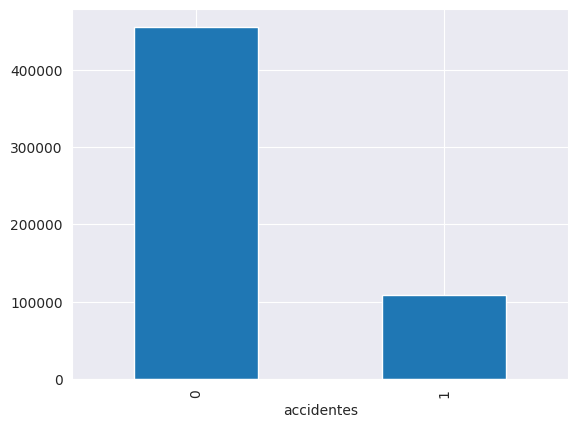

In [9]:
y_train.value_counts().plot.bar()

Para seleccioanar las características más relevantes se entrenó un modelo Random Forest. Se decisión utilizar esta técnica dado que muchas de las características contienen información similiar. 

In [10]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced"))
sel.fit(X_train, y_train)
características = list(X_train.columns[sel.get_support()])

# Características con importancia mayor que la media:
características

['cuadrante',
 'fila',
 'hora',
 'semana_del_año',
 'dia_de_la_semana',
 'mes',
 'accidente_14_dias_media_móvil',
 'accidente_21_dias_media_móvil',
 'accidente_28_dias_media_móvil',
 'accidentes_8_media_móvil_día',
 'accidentes_14_media_móvil_día',
 'accidentes_21_media_móvil_día',
 'accidentes_28_media_móvil_día']

In [11]:
preproc = make_column_transformer(
    (sin_transformer(24), ["hora"]),
    (cos_transformer(24), ["hora"]),
    (sin_transformer(7), ["dia_de_la_semana"]),
    (cos_transformer(7), ["dia_de_la_semana"]),
    (sin_transformer(12), ["mes"]),
    (cos_transformer(12), ["mes"]),
    (sin_transformer(53), ["semana_del_año"]),
    (cos_transformer(53), ["semana_del_año"]),
    (
        StandardScaler(),
        [
            'cuadrante',
            'fila',
            'accidente_14_dias_media_móvil',
            'accidente_21_dias_media_móvil',
            'accidente_28_dias_media_móvil',
            'accidentes_8_media_móvil_día',
            'accidentes_14_media_móvil_día',
            'accidentes_21_media_móvil_día',
            'accidentes_28_media_móvil_día'
        ]
    ),
)

## Regresión logística

In [12]:
lr_model = Pipeline([
    ("preprocesamiento", preproc),
    ("remuestreo", SMOTE()),
    ("modelo", LogisticRegression(class_weight="balanced")),
])

params_grid = [
    {
        "modelo__C": [0.1, 1, 10, 100],
        'remuestreo': ['passthrough', SMOTE()],
        'modelo__penalty': ['l2'],
    },
    {
        "modelo__C": [0.1, 1, 10, 100],
        "modelo__l1_ratio": [0.1, 0.5, 1],
        'remuestreo': ['passthrough', SMOTE()],
        'modelo__penalty': ['elasticnet'],
        'modelo__solver': ['saga']  # lbfgs no funciona con elasticnet
    }
]

lr_search = GridSearchCV(lr_model, params_grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=16)

lr_search.fit(X_train, y_train)

joblib.dump(lr_model, "models/lr_model.joblib")

pd.Series(lr_search.best_params_, name="valor").to_frame()

,valor
modelo__C,10
modelo__l1_ratio,0.5
modelo__penalty,elasticnet
modelo__solver,saga
remuestreo,SMOTE()


In [13]:
y_pred_lr = lr_search.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85    199041
           1       0.42      0.72      0.53     42597

    accuracy                           0.77    241638
   macro avg       0.67      0.75      0.69    241638
weighted avg       0.84      0.77      0.79    241638


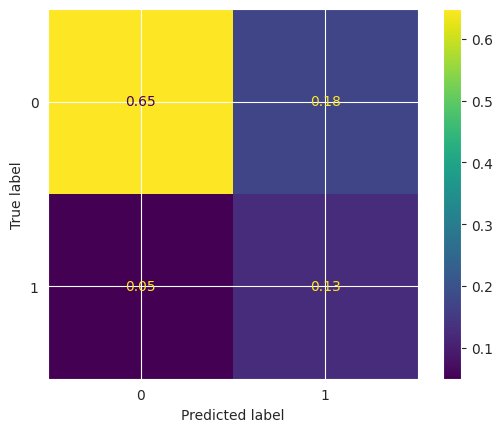

In [14]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr, normalize='all')).plot()

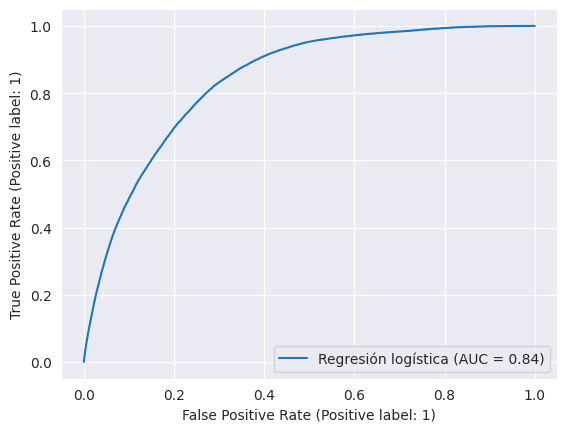

In [15]:
lr_roccurv = RocCurveDisplay.from_estimator(lr_search, X_test, y_test, name="Regresión logística")

## Random Forest

In [16]:
rf_model = Pipeline([
    ("preprocesamiento", preproc),
    ("remuestreo", SMOTE()),
    ("modelo", RandomForestClassifier(class_weight="balanced", n_jobs=10)),
])

params_grid = [
    {
        'remuestreo': ['passthrough', SMOTE()],
        'modelo__n_estimators': [100, 200],
        'modelo__max_depth': [1, 2, 4, 8]
    }
]

rf_search = GridSearchCV(rf_model, params_grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=8)

rf_search.fit(X_train, y_train)

joblib.dump(rf_search.best_estimator_, "models/rf_model.joblib")

pd.Series(rf_search.best_params_, name="valor").to_frame()

/home/maini/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,valor
modelo__max_depth,8
modelo__n_estimators,200
remuestreo,SMOTE()


In [17]:
y_pred_rf = rf_search.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84    199041
           1       0.41      0.77      0.53     42597

    accuracy                           0.76    241638
   macro avg       0.67      0.76      0.69    241638
weighted avg       0.84      0.76      0.79    241638


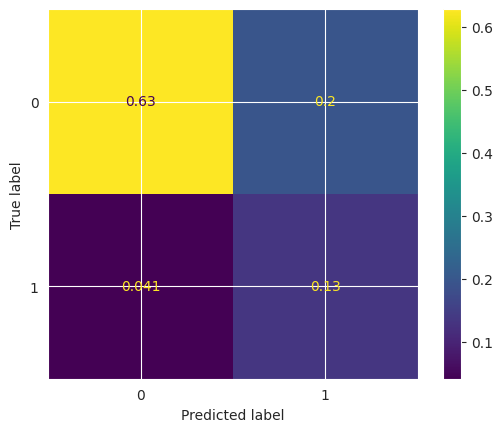

In [18]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf, normalize='all')).plot()

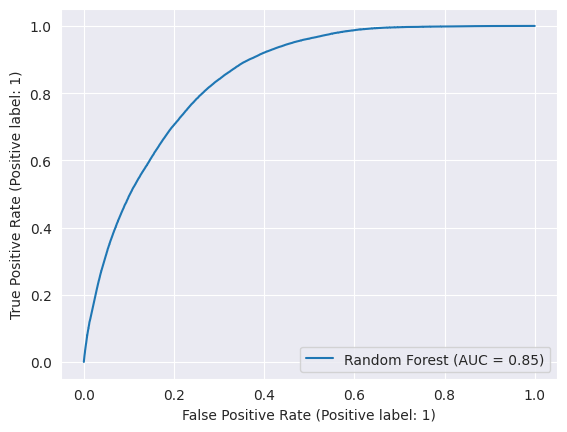

In [19]:
rf_roccurv = RocCurveDisplay.from_estimator(rf_search, X_test, y_test, name="Random Forest")

## XGBoost

In [22]:
xgb_model = Pipeline([
    ("preprocesamiento", preproc),
    ("remuestreo", SMOTE()),
    ("modelo", XGBClassifier()),
])

params_grid = [
    {
        'remuestreo': ['passthrough', SMOTE()],
        'modelo__n_estimators': [50, 100, 200],
        'modelo__scale_pos_weight': [1, 2, 4],
        'modelo__max_depth': [3, 4, 5],
        'modelo__learning_rate': [0.1, 0.2, 0.3],
        "modelo__gamma": [0, 0.5, 1],
    }
]

xgb_search = GridSearchCV(xgb_model, params_grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=-1)

xgb_search.fit(X_train, y_train)

joblib.dump(xgb_search.best_estimator_, "models/xgb_model.joblib")

pd.Series(xgb_search.best_params_, name="valor").to_frame()

,valor
modelo__gamma,0
modelo__learning_rate,0.2
modelo__max_depth,3
modelo__n_estimators,100
modelo__scale_pos_weight,2
remuestreo,SMOTE()


In [23]:
y_pred_xgb = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83    199041
           1       0.39      0.81      0.53     42597

    accuracy                           0.75    241638
   macro avg       0.67      0.77      0.68    241638
weighted avg       0.85      0.75      0.77    241638


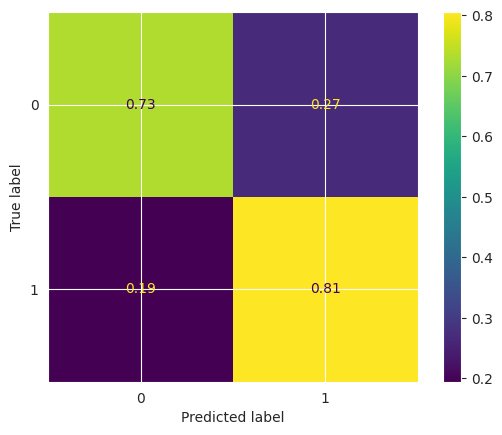

In [24]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_xgb, normalize='true', )).plot()

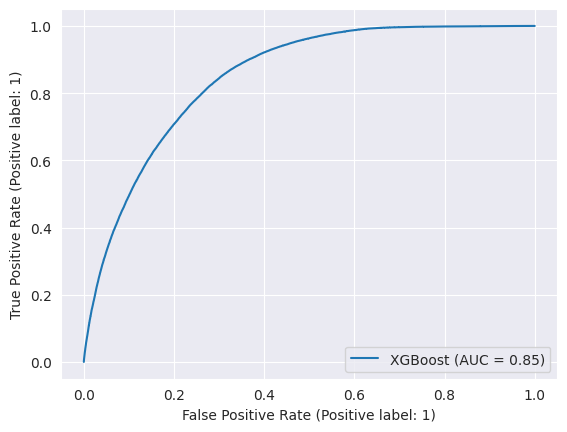

In [25]:
xgb_roccurv = RocCurveDisplay.from_estimator(xgb_search, X_test, y_test, name="XGBoost")

# Comparación de modelos

Text(0.5, 1.0, 'Comparación de la curva ROC de los tres modelos')

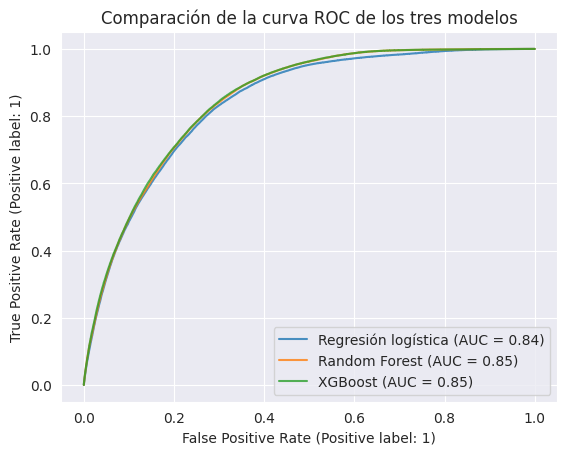

In [26]:
ax = plt.gca()

lr_roccurv.plot(ax=ax, alpha=0.8)
rf_roccurv.plot(ax=ax, alpha=0.8)
xgb_roccurv.plot(ax=ax, alpha=0.8)

plt.title("Comparación de la curva ROC de los tres modelos")

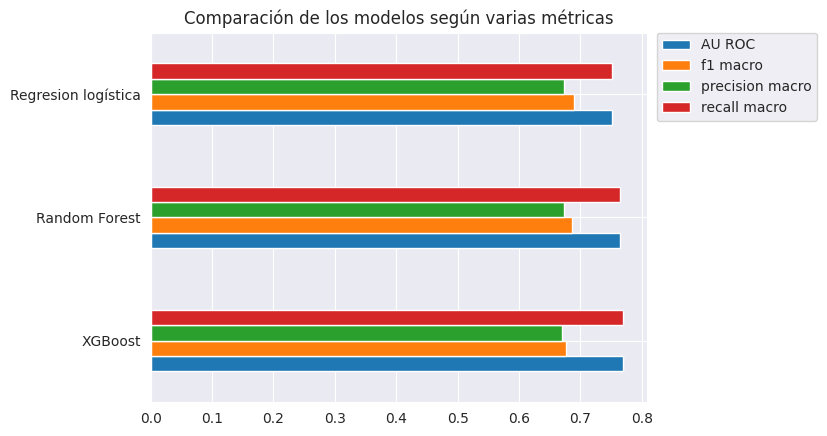

In [27]:
predicciones = {
    "Regresion logística": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
}

métricas = {
    "f1 macro": f1_score,
    "recall macro": recall_score,
    "precision macro": precision_score,
    "AU ROC": roc_auc_score,
}

ax = pd.Series(
    {(model, metrica): metric(y_test, pred, average="macro") for model, pred in predicciones.items() for metrica, metric
     in métricas.items()}
).unstack().sort_values("f1 macro").plot.barh(title="Comparación de los modelos según varias métricas")

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

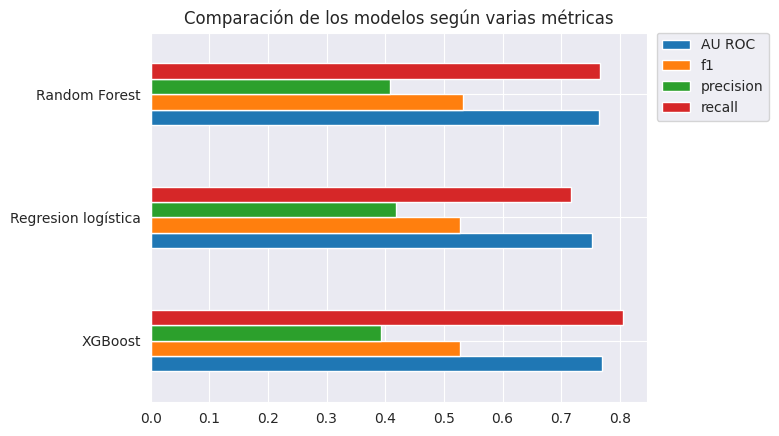

In [28]:
métricas = {
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
    "AU ROC": roc_auc_score,
}

pd.Series(
    {(model, metrica): metric(y_test, pred) for model, pred in predicciones.items() for metrica, metric in
     métricas.items()}
).unstack().sort_values("f1").plot.barh(title="Comparación de los modelos según varias métricas")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

De las gráficas anteriore spodemos observar que después de haber aplicado los cambios en cuanto a ingniería de características ya no existe una gran diferencia entre el rendimiento de los diferentes modelos. Sin embargo XGBoost continua manteniendo un rendimiento legeramente mayor.

<Axes: title={'center': 'Características utilizadas según su importancia en el modelo'}>

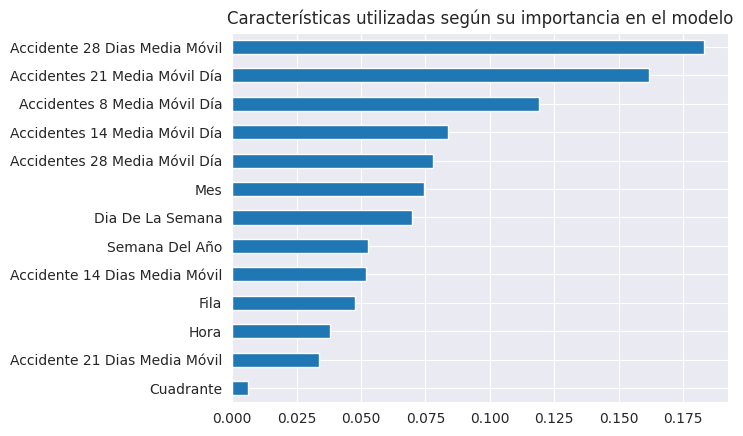

In [29]:
caracteristicas = pd.Series(
    xgb_search.best_estimator_[-1].feature_importances_,
    index=xgb_search.best_estimator_[:-1].get_feature_names_out()
)

caracteristicas.groupby(
    caracteristicas.index.map(lambda x: x.split("__")[-1].replace("_", " ").title())
).sum().sort_values().plot.barh(title="Características utilizadas según su importancia en el modelo")

## Umbral

In [11]:
model = joblib.load("models/xgb_model.joblib")

In [12]:
probas = model.predict_proba(X_test)[:, 1]

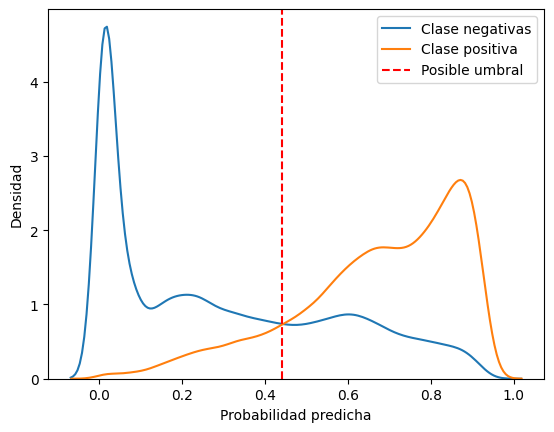

In [13]:
sns.kdeplot(probas[y_test == 0], label="Clase negativas")
sns.kdeplot(probas[y_test == 1], label="Clase positiva")

plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.axvline(x=.44, color="r", linestyle="--", label="Posible umbral")
plt.legend()


              precision    recall  f1-score   support

           0       0.96      0.69      0.80    199041
           1       0.37      0.85      0.52     42597

    accuracy                           0.72    241638
   macro avg       0.66      0.77      0.66    241638
weighted avg       0.85      0.72      0.75    241638



Text(0, 0.5, 'Etiquetas verdaderas')

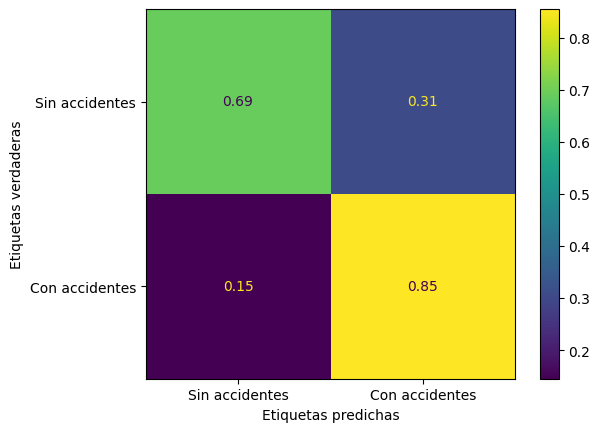

In [14]:
y_pred_xgb = np.where(model.predict_proba(X_test)[:, 1] > 0.44, 1, 0)

print(classification_report(y_test, y_pred_xgb))

a = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_xgb, normalize='true', ),
    display_labels=["Sin accidentes", "Con accidentes"]).plot()

a.ax_.set_xlabel("Etiquetas predichas")
a.ax_.set_ylabel("Etiquetas verdaderas")

# Salidas

In [15]:
df, grid = crear_dataset(accidentes_df, lapso="4h", rows=12, cols=6)
X = df.drop(columns=["accidentes", "n_accidentes", "fecha_y_hora"])
y = df["accidentes"]
fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

A continuación presentamos como ejemplo el cálculo de la probabilidad de ocurrencia de accidentes para diferentes horas del día:

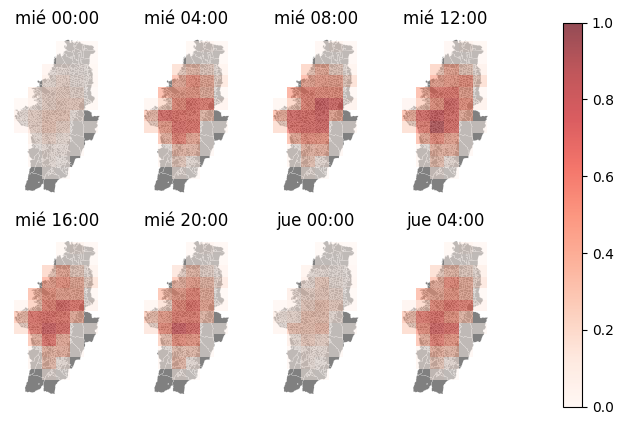

In [15]:
import locale

locale.setlocale(locale.LC_ALL, "es_CO.utf-8")

fig, axis = plt.subplots(2, 4)
test_predictions = X_test.assign(proba=model.predict_proba(X_test)[:, 1])[["proba"]].join(df)
fechas = pd.Series(test_predictions['fecha_y_hora'].unique()[-8:])

for fecha, ax in zip(fechas, axis.flat):
    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=1, fc="gray", ec="white", lw=0.1)
    grid.join(
        test_predictions[test_predictions['fecha_y_hora'] == fecha].set_index("cuadrante"),
        how="inner"
    ).plot(column="proba", ax=ax, alpha=0.5, vmin=0, vmax=1, cmap="Reds")
    ax.set_title(f"{fecha:%a %H:%M}")

    ax.axis("off")

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
fig.colorbar(sm, cax=cax, alpha=0.7)

# Entrenando modelos para diferentes tamaños de grilla

Dado que el tamaño de grilla presentado puede ser aun muy poco preciso en términos geográficos, en este apartado se procede a estimar múltiples modelos para diferentes tamaños de grilla y evaluar su rendimiento:

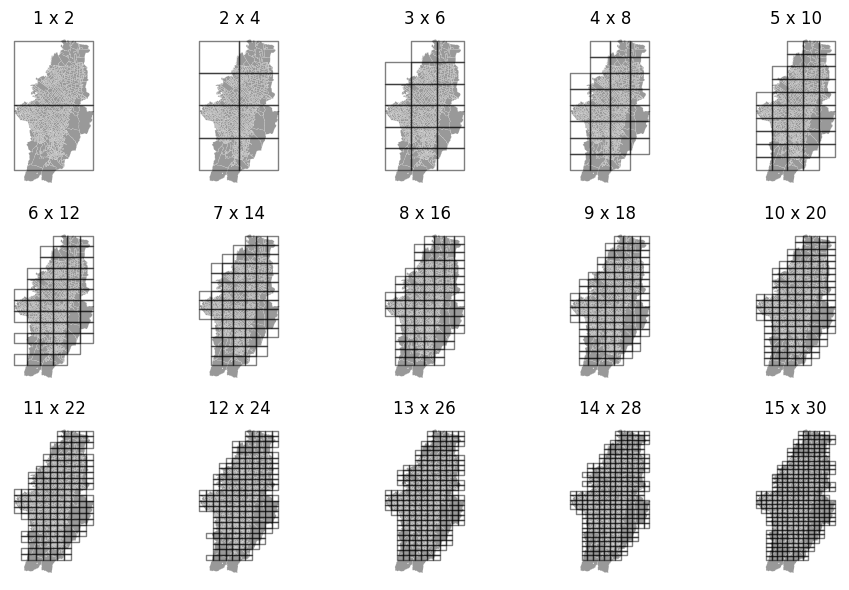

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for cols, ax in enumerate(axes.flat):
    cols = cols + 1
    rows = 2 * cols
    df, grid = asignar_cuadrante(accidentes_df, cols=cols, rows=rows)
    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=0.8, fc="gray", ec="white", lw=0.1)
    grid.plot(fc="none", ec="black", alpha=0.5, ax=ax)
    ax.set_title(f"{cols} x {rows}")
    ax.axis("off")

plt.tight_layout()

In [17]:
métricas = {
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
    "Área bajo roc": precision_score,
}

results = {}

for cols in range(16):
    cols = cols + 1
    rows = 2 * cols

    df, grid = crear_dataset(accidentes_df, lapso="4h", rows=rows, cols=cols)
    X = df.drop(columns=["accidentes", "n_accidentes", "fecha_y_hora"])
    y = df["accidentes"]
    fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

    X_train = X[fecha_corte_test_train]
    X_test = X[~fecha_corte_test_train]

    y_train = y[fecha_corte_test_train]
    y_test = y[~fecha_corte_test_train]

    model.fit(X_train, y_train)

    joblib.dump(model, f"models/model_{cols}x{rows}.joblib")

    results[f'{cols}x{rows}'] = {metrica: metric(y_test, model.predict(X_test)) for metrica, metric in métricas.items()}


In [18]:
pd.DataFrame(results)

,1x2,2x4,3x6,4x8,5x10,6x12,7x14,8x16,9x18,10x20,11x22,12x24,13x26,14x28,15x30,16x32
f1,0.961138,0.826441,0.744528,0.669423,0.586574,0.530132,0.480550,0.420755,0.366716,0.337954,0.299971,0.271327,0.245414,0.224335,0.203074,0.184715
recall,0.967478,0.870532,0.850834,0.851160,0.840753,0.770864,0.776116,0.739840,0.671646,0.623431,0.551130,0.559448,0.467002,0.463325,0.439102,0.440844
precision,0.954880,0.786601,0.661836,0.551639,0.450406,0.403975,0.348016,0.293970,0.252211,0.231807,0.206064,0.179092,0.166440,0.147996,0.132079,0.116835
Área bajo roc,0.954880,0.786601,0.661836,0.551639,0.450406,0.403975,0.348016,0.293970,0.252211,0.231807,0.206064,0.179092,0.166440,0.147996,0.132079,0.116835


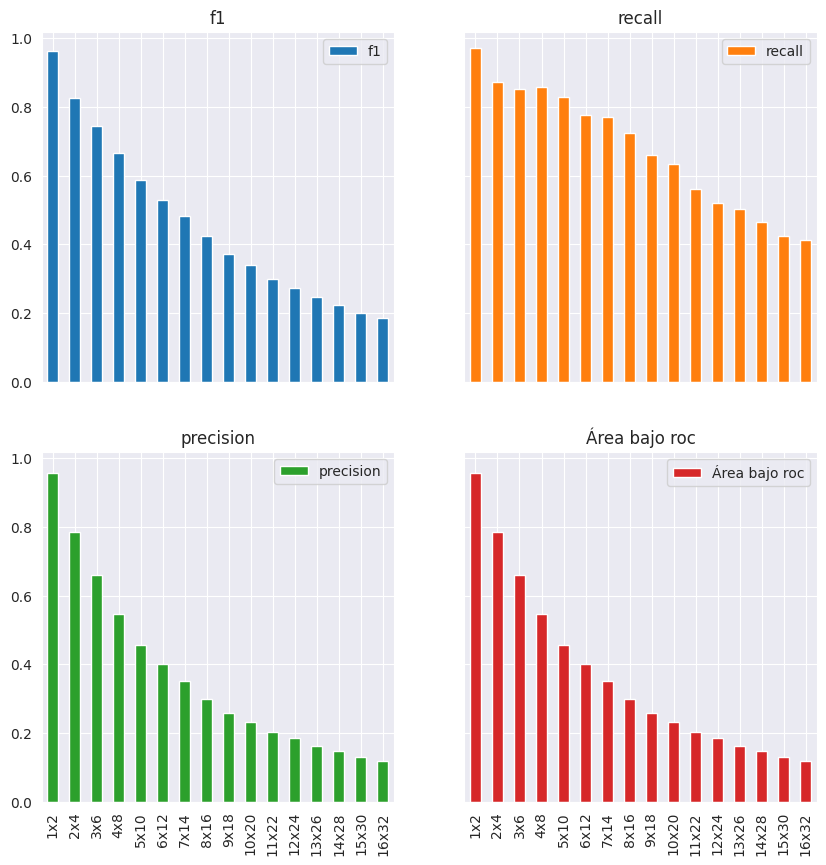

In [38]:
(
    pd.DataFrame(results).T
    .plot(subplots=True, layout=(2, 2), sharex=True, sharey=True, kind="bar", figsize=(10, 10))
);

De la gráfica anterior podemos concluir, como era de esperarse, que entre mayor sea el detalle geográfico más dificil es el problema de clasificacxión y por lo tanto menor el rendimiento del modelo medido a través de las diferentes métricas. En particular observamos que en tamaños de grilla de **8x16** cerca del **74%** de los accidentes ocurrirían en zonas de alta probabilidad, mientras que en el mayor detalle, **16x32**, este porcentaje se reduce al **44%**.

## Salida

Estos modelo nos permiten generar como salida una estimación de las probabilidades de ocurrencia con diferentes niveles de detalle sobre el mapa, con la consecuente pérdida de rendimiento en los mapas de mayor detalle:

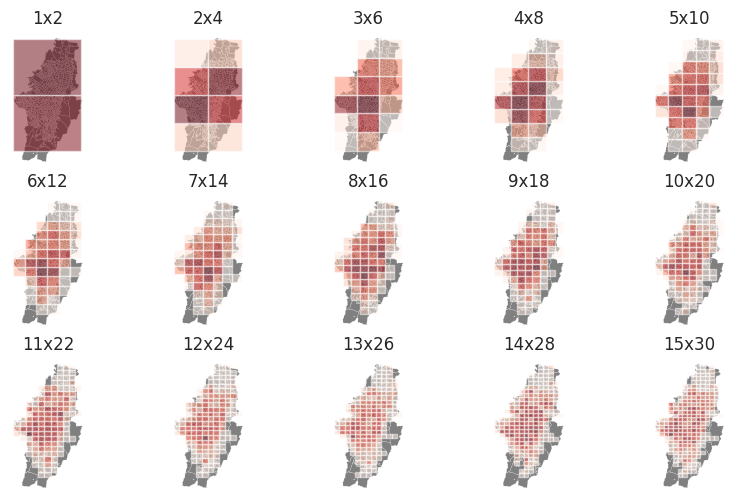

In [39]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for cols, ax in enumerate(axes.flat):
    cols = cols + 1
    rows = 2 * cols

    df, grid = crear_dataset(accidentes_df, lapso="4h", rows=rows, cols=cols)

    X = df.drop(columns=["accidentes", "n_accidentes", "fecha_y_hora"])
    y = df["accidentes"]
    fecha_corte_test_train = df["fecha_y_hora"] <= df["fecha_y_hora"].quantile(0.7)

    X_train = X[fecha_corte_test_train]
    X_test = X[~fecha_corte_test_train]

    y_train = y[fecha_corte_test_train]
    y_test = y[~fecha_corte_test_train]

    model = joblib.load(f"models/model_{cols}x{rows}.joblib")

    mapa_bogota_no_sumapaz.plot(ax=ax, alpha=1, fc="gray", ec="white", lw=0.1)

    test_data = df[df['fecha_y_hora'] == df["fecha_y_hora"].max()]
    test_predictions = test_data.assign(proba=model.predict_proba(test_data)[:, 1])

    grid.join(
        test_predictions.set_index("cuadrante"),
        how="inner"
    ).plot(column="proba", ax=ax, alpha=0.5, cmap="Reds", vmin=0)  # , vmin=0, vmax=1
    ax.set_title(f"{cols}x{rows}")
    ax.axis("off")

# sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
# cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# fig.colorbar(sm, cax=cax, alpha=0.7)